In [3]:
%matplotlib inline


 NEST Topology Module: A Case-Based Tutorial
 ===========================================

 :Author: Hans Ekkehard Plesser
 :Institution: Norwegian University of Life Sciences
 :Version: 0.4
 :Date: 21 November 2012
 :Copyright: The NEST Initiative (2004)
 :License: Creative Commons Attribution License

 **NOTE:** The network generated by this script does generate
 dynamics in which the activity of the entire system, especially
 Rp and Vp oscillates with approx 5 Hz. This is different from
 the full model. Deviations are due to the different model type
 and the elimination of a number of connections, with no changes
 to the weights.

 Introduction
 ============

 This tutorial shows you how to implement a simplified version of the
 Hill-Tononi model of the early visual pathway using the NEST Topology
 module.  The model is described in the paper

   S. L. Hill and G. Tononi.
   Modeling Sleep and Wakefulness in the Thalamocortical System.
   J Neurophysiology **93**:1671-1698 (2005).
   Freely available via `doi 10.1152/jn.00915.2004
   <http://dx.doi.org/10.1152/jn.00915.2004>`_.

 We simplify the model somewhat both to keep this tutorial a bit
 shorter, and because some details of the Hill-Tononi model are not
 currently supported by NEST. Simplifications include:

 1. We use the ``iaf_cond_alpha`` neuron model, which is
    simpler than the Hill-Tononi model.

 #. As the ``iaf_cond_alpha`` neuron model only supports two
    synapses (labeled "ex" and "in"), we only include AMPA and
    GABA_A synapses.

 #. We ignore the secondary pathway (Ts, Rs, Vs), since it adds just
    more of the same from a technical point of view.

 #. Synaptic delays follow a Gaussian distribution in the HT
    model. This implies actually a Gaussian distributions clipped at
    some small, non-zero delay, since delays must be
    positive. Currently, there is a bug in the Topology module when
    using clipped Gaussian distribution. We therefore draw delays from a
    uniform distribution.

 #. Some further adaptations are given at the appropriate locations in
    the script.

 This tutorial is divided in the following sections:

 Philosophy_
    Discusses the philosophy applied to model implementation in this
    tutorial

 Preparations_
    Neccessary steps to use NEST and the Topology Module

 `Configurable Parameters`_
    Define adjustable network parameters

 `Neuron Models`_
    Define the neuron models needed by the network model

 Populations_
    Create Populations

 `Synapse models`_
    Define the synapse models used in the network model

 Connections_
    Create Connections

 `Example simulation`_
    Perform a small simulation for illustration. This
    section also discusses the setup for recording.

 Philosophy
 ==========

 A network models has two essential components: *populations* and
 *projections*.  We first use NEST's ``CopyModel()`` mechanism to
 create specific models for all populations and subpopulations in
 the network, and then create the populations using the Topology
 modules ``CreateLayer()`` function.

 We use a two-stage process to create the connections, mainly
 because the same configurations are required for a number of
 projections: we first define dictionaries specifying the
 connections, then apply these dictionaries later.

 The way in which we declare the network model here is an
 example. You should not consider it the last word: we expect to see
 a significant development in strategies and tools for network
 descriptions in the future. The following contributions to CNS\*09
 seem particularly interesting

 - Ralf Ansorg & Lars Schwabe. Declarative model description and
   code generation for hybrid individual- and population-based
   simulations of the early visual system (P57);
 - Sharon Crook, R. Angus Silver, & Padraig Gleeson. Describing
   and exchanging models of neurons and neuronal networks with
   NeuroML (F1);

 as well as the following paper which will apply in PLoS
 Computational Biology shortly:

 - Eilen Nordlie, Marc-Oliver Gewaltig, & Hans Ekkehard Plesser.
   Towards reproducible descriptions of neuronal network models.

 Preparations
 ============

 Please make sure that your ``PYTHONPATH`` is set correctly, so
 that Python can find the NEST Python module.

 **Note:** By default, the script does not show any graphics.
 Set ``SHOW_FIGURES`` to ``True`` to activate graphics.

 This example uses the function GetLeaves, which is deprecated. A
 deprecation warning is therefore issued. For details about deprecated
 functions, see documentation.



Connecting: cortico-cortical, same orientation
Connecting: cortico-cortical, other orientation
Connecting: cortico-thalamic
Connecting: thalamo-cortical
Connecting: intra-thalamic
Connecting: retino-thalamic
Connecting: Recording devices
{'adaptive_spike_buffers': True, 'adaptive_target_buffers': True, 'buffer_size_secondary_events': 0, 'buffer_size_spike_data': 27310, 'buffer_size_target_data': 39997, 'data_path': '', 'data_prefix': '', 'dict_miss_is_error': True, 'grng_seed': 0, 'growth_factor_buffer_spike_data': 1.5, 'growth_factor_buffer_target_data': 1.5, 'keep_source_table': True, 'local_num_threads': 1, 'local_spike_counter': 76420, 'max_buffer_size_spike_data': 8388608, 'max_buffer_size_target_data': 16777216, 'max_num_syn_models': 512, 'max_delay': 8.5, 'min_delay': 1.0, 'ms_per_tic': 0.001, 'network_size': 35210, 'num_connections': 4466448, 'num_processes': 1, 'off_grid_spiking': False, 'overwrite_files': False, 'print_time': True, 'resolution': 0.1, 'rng_seeds': (1,), 'sort_

/home/juanmav/anaconda3/envs/spiking/lib/python3.7/site-packages/ipykernel_launcher.py:718: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


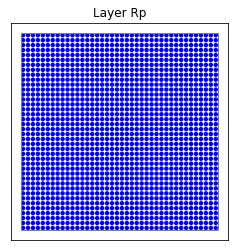

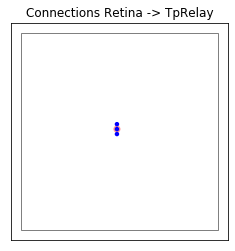

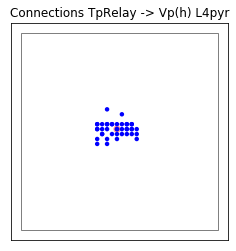

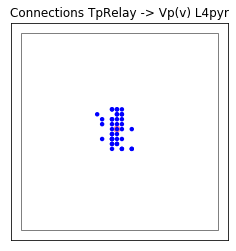

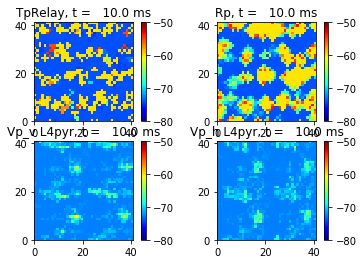

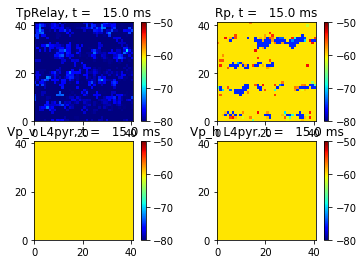

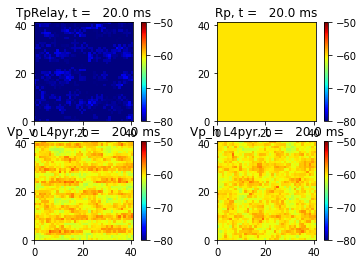

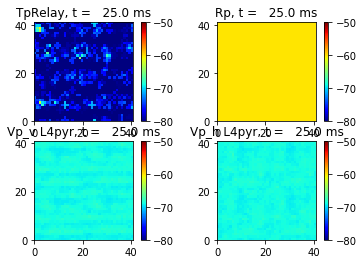

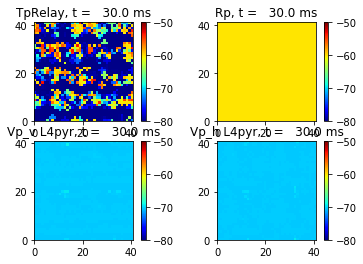

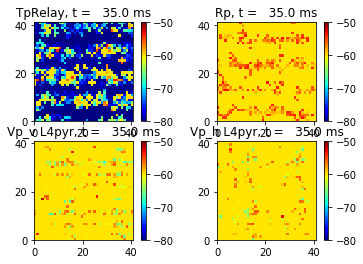

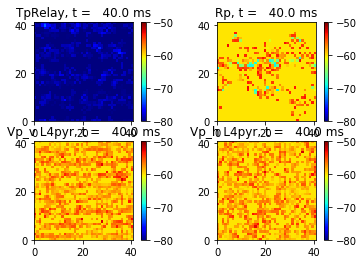

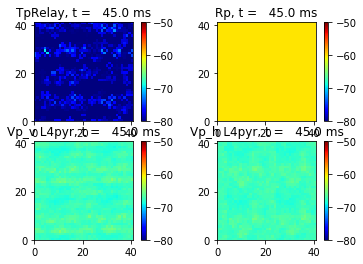

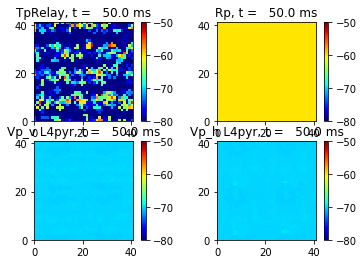

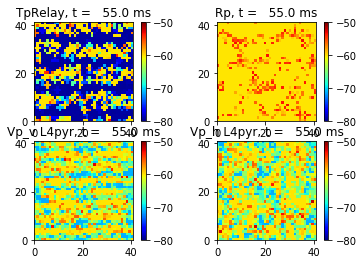

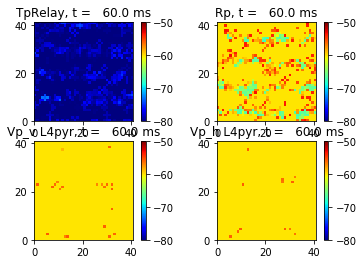

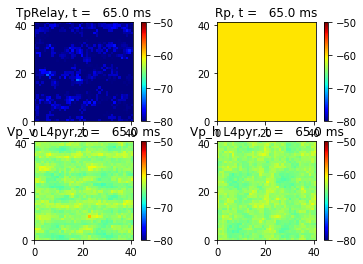

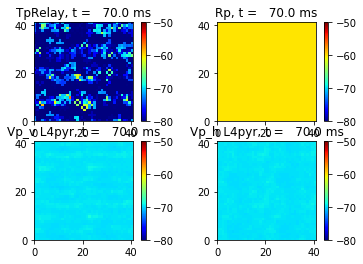

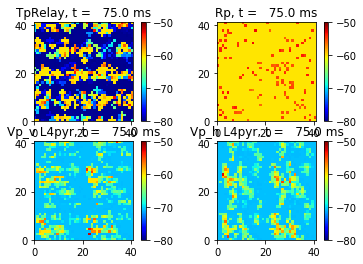

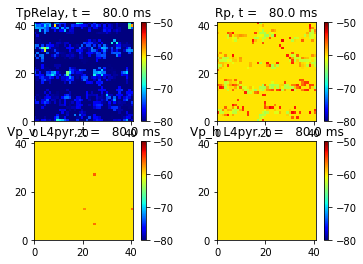

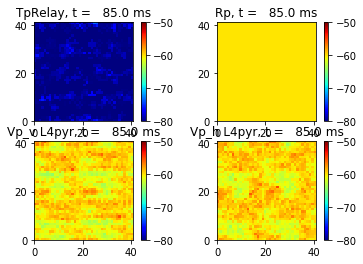

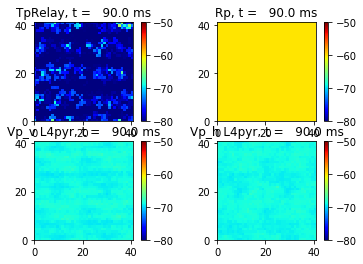

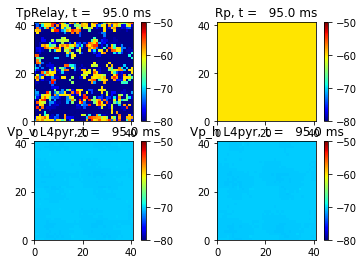

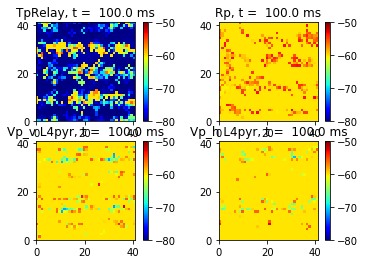

In [4]:
import pylab
SHOW_FIGURES = False

if not SHOW_FIGURES:
    pylab_show = pylab.show

    def nop(s=None):
        pass

    pylab.show = nop
else:
    pylab.ion()

# ! Introduction
# !=============
# ! This tutorial gives a brief introduction to the ConnPlotter
# ! toolbox.  It is by no means complete.

# ! Load pynest
import nest

# ! Load NEST Topoplogy module (NEST 2.2)
import nest.topology as topo

# ! Make sure we start with a clean slate, even if we re-run the script
# ! in the same Python session.
nest.ResetKernel()

# ! Import math, we need Pi
import math

# ! Configurable Parameters
# ! =======================
# !
# ! Here we define those parameters that we take to be
# ! configurable. The choice of configurable parameters is obviously
# ! arbitrary, and in practice one would have far more configurable
# ! parameters. We restrict ourselves to:
# !
# ! - Network size in neurons ``N``, each layer is ``N x N``.
# ! - Network size in subtended visual angle ``visSize``, in degree.
# ! - Temporal frequency of drifting grating input ``f_dg``, in Hz.
# ! - Spatial wavelength and direction of drifting grating input,
# !   ``lambda_dg`` and ``phi_dg``, in degree/radian.
# ! - Background firing rate of retinal nodes and modulation amplitude,
# !   ``retDC`` and ``retAC``, in Hz.
# ! - Simulation duration ``simtime``; actual simulation is split into
# !   intervals of ``sim_interval`` length, so that the network state
# !   can be visualized in those intervals. Times are in ms.
Params = {'N': 40,
          'visSize': 8.0,
          'f_dg': 2.0,
          'lambda_dg': 2.0,
          'phi_dg': 0.0,
          'retDC': 30.0,
          'retAC': 30.0,
          'simtime': 100.0,
          'sim_interval': 5.0
          }

# ! Neuron Models
# ! =============
# !
# ! We declare models in two steps:
# !
# ! 1. We define a dictionary specifying the NEST neuron model to use
# !    as well as the parameters for that model.
# ! #. We create three copies of this dictionary with parameters
# !    adjusted to the three model variants specified in Table~2 of
# !    Hill & Tononi (2005) (cortical excitatory, cortical inhibitory,
# !    thalamic)
# !
# ! In addition, we declare the models for the stimulation and
# ! recording devices.
# !
# ! The general neuron model
# ! ------------------------
# !
# ! We use the ``iaf_cond_alpha`` neuron, which is an
# ! integrate-and-fire neuron with two conductance-based synapses which
# ! have alpha-function time course.  Any input with positive weights
# ! will automatically directed to the synapse labeled ``_ex``, any
# ! with negative weights to the synapes labeled ``_in``.  We define
# ! **all** parameters explicitly here, so that no information is
# ! hidden in the model definition in NEST. ``V_m`` is the membrane
# ! potential to which the model neurons will be initialized.
# ! The model equations and parameters for the Hill-Tononi neuron model
# ! are given on pp. 1677f and Tables 2 and 3 in that paper. Note some
# ! peculiarities and adjustments:
# !
# ! - Hill & Tononi specify their model in terms of the membrane time
# !   constant, while the ``iaf_cond_alpha`` model is based on the
# !   membrane capcitance. Interestingly, conducantces are unitless in
# !   the H&T model. We thus can use the time constant directly as
# !   membrane capacitance.
# ! - The model includes sodium and potassium leak conductances. We
# !   combine these into a single one as follows:
# $   \begin{equation}-g_{NaL}(V-E_{Na}) - g_{KL}(V-E_K)
# $      = -(g_{NaL}+g_{KL})
# $        \left(V-\frac{g_{NaL}E_{NaL}+g_{KL}E_K}{g_{NaL}g_{KL}}\right)
# $   \end{equation}
# ! - We write the resulting expressions for g_L and E_L explicitly
# !   below, to avoid errors in copying from our pocket calculator.
# ! - The paper gives a range of 1.0-1.85 for g_{KL}, we choose 1.5
# !   here.
# ! - The Hill-Tononi model has no explicit reset or refractory
# !   time. We arbitrarily set V_reset and t_ref.
# ! - The paper uses double exponential time courses for the synaptic
# !   conductances, with separate time constants for the rising and
# !   fallings flanks. Alpha functions have only a single time
# !   constant: we use twice the rising time constant given by Hill and
# !   Tononi.
# ! - In the general model below, we use the values for the cortical
# !   excitatory cells as defaults. Values will then be adapted below.
# !
nest.CopyModel('iaf_cond_alpha', 
               'NeuronModel',
               params={
                   'C_m': 16.0,
                    'E_L': (0.2 * 30.0 + 1.5 * -90.0) / (0.2 + 1.5),
                    'g_L': 0.2 + 1.5,
                    'E_ex': 0.0,
                    'E_in': -70.0,
                    'V_reset': -60.0,
                    'V_th': -51.0,
                    't_ref': 2.0,
                    'tau_syn_ex': 1.0,
                    'tau_syn_in': 2.0,
                    'I_e': 0.0,
                    'V_m': -70.0
               }
               )

# ! Adaptation of models for different populations
# ! ----------------------------------------------

# ! We must copy the `NeuronModel` dictionary explicitly, otherwise
# ! Python would just create a reference.

# ! Cortical excitatory cells
# ! .........................
# ! Parameters are the same as above, so we need not adapt anything
nest.CopyModel('NeuronModel', 'CtxExNeuron')

# ! Cortical inhibitory cells
# ! .........................
nest.CopyModel('NeuronModel', 'CtxInNeuron',
               params={'C_m': 8.0,
                       'V_th': -53.0,
                       't_ref': 1.0})

# ! Thalamic cells
# ! ..............
nest.CopyModel('NeuronModel', 'ThalamicNeuron',
               params={'C_m': 8.0,
                       'V_th': -53.0,
                       't_ref': 1.0,
                       'E_in': -80.0})


# ! Input generating nodes
# ! ----------------------

# ! Input is generated by sinusoidally modulate Poisson generators,
# ! organized in a square layer of retina nodes. These nodes require a
# ! slightly more complicated initialization than all other elements of
# ! the network:
# !
# ! - Average firing rate ``rate``, firing rate modulation depth ``amplitude``,
# !   and temporal modulation frequency ``frequency`` are the same for all
# !   retinal nodes and are set directly below.
# ! - The temporal phase ``phase`` of each node depends on its position in
# !   the grating and can only be assigned after the retinal layer has
# !   been created. We therefore specify a function for initalizing the
# !   ``phase``. This function will be called for each node.
def phaseInit(pos, lam, alpha):
    '''Initializer function for phase of drifting grating nodes.

       pos  : position (x,y) of node, in degree
       lam  : wavelength of grating, in degree
       alpha: angle of grating in radian, zero is horizontal

       Returns number to be used as phase of sinusoidal Poisson generator.
    '''
    return 360.0 / lam * (math.cos(alpha) * pos[0] + math.sin(alpha) * pos[1])


nest.CopyModel('sinusoidal_poisson_generator', 'RetinaNode',
               params={'amplitude': Params['retAC'],
                       'rate': Params['retDC'],
                       'frequency': Params['f_dg'],
                       'phase': 0.0,
                       'individual_spike_trains': False})

# ! Recording nodes
# ! ---------------

# ! We use the new ``multimeter`` device for recording from the model
# ! neurons. At present, ``iaf_cond_alpha`` is one of few models
# ! supporting ``multimeter`` recording.  Support for more models will
# ! be added soon; until then, you need to use ``voltmeter`` to record
# ! from other models.
# !
# ! We configure multimeter to record membrane potential to membrane
# ! potential at certain intervals to memory only. We record the GID of
# ! the recorded neurons, but not the time.
nest.CopyModel('multimeter', 'RecordingNode',
               params={'interval': Params['sim_interval'],
                       'record_from': ['V_m'],
                       'record_to': ['memory'],
                       'withgid': True,
                       'withtime': False})

# ! Populations
# ! ===========

# ! We now create the neuron populations in the model, again in the
# ! form of Python dictionaries. We define them in order from eye via
# ! thalamus to cortex.
# !
# ! We first define a dictionary defining common properties for all
# ! populations
layerProps = {'rows': Params['N'],
              'columns': Params['N'],
              'extent': [Params['visSize'], Params['visSize']],
              'edge_wrap': True}
# ! This dictionary does not yet specify the elements to put into the
# ! layer, since they will differ from layer to layer. We will add them
# ! below by updating the ``'elements'`` dictionary entry for each
# ! population.

# ! Retina
# ! ------
layerProps.update({'elements': 'RetinaNode'})
retina = topo.CreateLayer(layerProps)

# retina_leaves is a work-around until NEST 3.0 is released
retina_leaves = nest.GetLeaves(retina)[0]

# ! Now set phases of retinal oscillators; we use a list comprehension instead
# ! of a loop.
[nest.SetStatus([n], {"phase": phaseInit(topo.GetPosition([n])[0],
                                         Params["lambda_dg"],
                                         Params["phi_dg"])})
 for n in retina_leaves]

# ! Thalamus
# ! --------

# ! We first introduce specific neuron models for the thalamic relay
# ! cells and interneurons. These have identical properties, but by
# ! treating them as different models, we can address them specifically
# ! when building connections.
# !
# ! We use a list comprehension to do the model copies.
[nest.CopyModel('ThalamicNeuron', SpecificModel) for SpecificModel in
 ('TpRelay', 'TpInter')]

# ! Now we can create the layer, with one relay cell and one
# ! interneuron per location:
layerProps.update({'elements': ['TpRelay', 'TpInter']})
Tp = topo.CreateLayer(layerProps)

# ! Reticular nucleus
# ! -----------------
# ! We follow the same approach as above, even though we have only a
# ! single neuron in each location.
[nest.CopyModel('ThalamicNeuron', SpecificModel) for SpecificModel in
 ('RpNeuron',)]
layerProps.update({'elements': 'RpNeuron'})
Rp = topo.CreateLayer(layerProps)

# ! Primary visual cortex
# ! ---------------------

# ! We follow again the same approach. We differentiate neuron types
# ! between layers and between pyramidal cells and interneurons. At
# ! each location, there are two pyramidal cells and one interneuron in
# ! each of layers 2-3, 4, and 5-6. Finally, we need to differentiate
# ! between vertically and horizontally tuned populations. When creating
# ! the populations, we create the vertically and the horizontally
# ! tuned populations as separate populations.

# ! We use list comprehesions to create all neuron types:
[nest.CopyModel('CtxExNeuron', layer + 'pyr')
 for layer in ('L23', 'L4', 'L56')]
[nest.CopyModel('CtxInNeuron', layer + 'in')
 for layer in ('L23', 'L4', 'L56')]

# ! Now we can create the populations, suffixes h and v indicate tuning
layerProps.update({'elements': ['L23pyr', 2, 'L23in', 1,
                                'L4pyr', 2, 'L4in', 1,
                                'L56pyr', 2, 'L56in', 1]})
Vp_h = topo.CreateLayer(layerProps)
Vp_v = topo.CreateLayer(layerProps)

# ! Collect all populations
# ! -----------------------

# ! For reference purposes, e.g., printing, we collect all populations
# ! in a tuple:
populations = (retina, Tp, Rp, Vp_h, Vp_v)

# ! Inspection
# ! ----------

# ! We can now look at the network using `PrintNetwork`:
nest.PrintNetwork()

# ! We can also try to plot a single layer in a network. For
# ! simplicity, we use Rp, which has only a single neuron per position.
topo.PlotLayer(Rp)
pylab.title('Layer Rp')
pylab.show()

# ! Synapse models
# ! ==============

# ! Actual synapse dynamics, e.g., properties such as the synaptic time
# ! course, time constants, reversal potentials, are properties of
# ! neuron models in NEST and we set them in section `Neuron models`_
# ! above. When we refer to *synapse models* in NEST, we actually mean
# ! connectors which store information about connection weights and
# ! delays, as well as port numbers at the target neuron (``rport``)
# ! and implement synaptic plasticity. The latter two aspects are not
# ! relevant here.
# !
# ! We just use NEST's ``static_synapse`` connector but copy it to
# ! synapse models ``AMPA`` and ``GABA_A`` for the sake of
# ! explicitness. Weights and delays are set as needed in section
# ! `Connections`_ below, as they are different from projection to
# ! projection. De facto, the sign of the synaptic weight decides
# ! whether input via a connection is handle by the ``_ex`` or the
# ! ``_in`` synapse.
nest.CopyModel('static_synapse', 'AMPA')
nest.CopyModel('static_synapse', 'GABA_A')

# ! Connections
# ! ====================

# ! Building connections is the most complex part of network
# ! construction. Connections are specified in Table 1 in the
# ! Hill-Tononi paper. As pointed out above, we only consider AMPA and
# ! GABA_A synapses here.  Adding other synapses is tedious work, but
# ! should pose no new principal challenges. We also use a uniform in
# ! stead of a Gaussian distribution for the weights.
# !
# ! The model has two identical primary visual cortex populations,
# ! ``Vp_v`` and ``Vp_h``, tuned to vertical and horizonal gratings,
# ! respectively. The *only* difference in the connection patterns
# ! between the two populations is the thalamocortical input to layers
# ! L4 and L5-6 is from a population of 8x2 and 2x8 grid locations,
# ! respectively. Furthermore, inhibitory connection in cortex go to
# ! the opposing orientation population as to the own.
# !
# ! To save us a lot of code doubling, we thus defined properties
# ! dictionaries for all connections first and then use this to connect
# ! both populations. We follow the subdivision of connections as in
# ! the Hill & Tononi paper.
# !
# ! **Note:** Hill & Tononi state that their model spans 8 degrees of
# ! visual angle and stimuli are specified according to this. On the
# ! other hand, all connection patterns are defined in terms of cell
# ! grid positions. Since the NEST Topology Module defines connection
# ! patterns in terms of the extent given in degrees, we need to apply
# ! the following scaling factor to all lengths in connections:
dpc = Params['visSize'] / (Params['N'] - 1)

# ! We will collect all same-orientation cortico-cortical connections in
ccConnections = []
# ! the cross-orientation cortico-cortical connections in
ccxConnections = []
# ! and all cortico-thalamic connections in
ctConnections = []

# ! Horizontal intralaminar
# ! -----------------------
# ! *Note:* "Horizontal" means "within the same cortical layer" in this
# ! case.
# !
# ! We first define a dictionary with the (most) common properties for
# ! horizontal intralaminar connection. We then create copies in which
# ! we adapt those values that need adapting, and
horIntraBase = {"connection_type": "divergent",
                "synapse_model": "AMPA",
                "mask": {"circular": {"radius": 12.0 * dpc}},
                "kernel": {"gaussian": {"p_center": 0.05, "sigma": 7.5 * dpc}},
                "weights": 1.0,
                "delays": {"uniform": {"min": 1.75, "max": 2.25}}}

# ! We use a loop to do the for for us. The loop runs over a list of
# ! dictionaries with all values that need updating
for conn in [{"sources": {"model": "L23pyr"}, "targets": {"model": "L23pyr"}},
             {"sources": {"model": "L23pyr"}, "targets": {"model": "L23in"}},
             {"sources": {"model": "L4pyr"}, "targets": {"model": "L4pyr"},
              "mask": {"circular": {"radius": 7.0 * dpc}}},
             {"sources": {"model": "L4pyr"}, "targets": {"model": "L4in"},
              "mask": {"circular": {"radius": 7.0 * dpc}}},
             {"sources": {"model": "L56pyr"}, "targets": {"model": "L56pyr"}},
             {"sources": {"model": "L56pyr"}, "targets": {"model": "L56in"}}]:
    ndict = horIntraBase.copy()
    ndict.update(conn)
    ccConnections.append(ndict)

# ! Vertical intralaminar
# ! -----------------------
# ! *Note:* "Vertical" means "between cortical layers" in this
# ! case.
# !
# ! We proceed as above.
verIntraBase = {"connection_type": "divergent",
                "synapse_model": "AMPA",
                "mask": {"circular": {"radius": 2.0 * dpc}},
                "kernel": {"gaussian": {"p_center": 1.0, "sigma": 7.5 * dpc}},
                "weights": 2.0,
                "delays": {"uniform": {"min": 1.75, "max": 2.25}}}

for conn in [{"sources": {"model": "L23pyr"}, "targets": {"model": "L56pyr"},
              "weights": 1.0},
             {"sources": {"model": "L23pyr"}, "targets": {"model": "L23in"},
              "weights": 1.0},
             {"sources": {"model": "L4pyr"}, "targets": {"model": "L23pyr"}},
             {"sources": {"model": "L4pyr"}, "targets": {"model": "L23in"}},
             {"sources": {"model": "L56pyr"}, "targets": {"model": "L23pyr"}},
             {"sources": {"model": "L56pyr"}, "targets": {"model": "L23in"}},
             {"sources": {"model": "L56pyr"}, "targets": {"model": "L4pyr"}},
             {"sources": {"model": "L56pyr"}, "targets": {"model": "L4in"}}]:
    ndict = verIntraBase.copy()
    ndict.update(conn)
    ccConnections.append(ndict)

# ! Intracortical inhibitory
# ! ------------------------
# !
# ! We proceed as above, with the following difference: each connection
# ! is added to the same-orientation and the cross-orientation list of
# ! connections.
# !
# ! **Note:** Weights increased from -1.0 to -2.0, to make up for missing GabaB
# !
# ! Note that we have to specify the **weight with negative sign** to make
# ! the connections inhibitory.
intraInhBase = {"connection_type": "divergent",
                "synapse_model": "GABA_A",
                "mask": {"circular": {"radius": 7.0 * dpc}},
                "kernel": {"gaussian": {"p_center": 0.25, "sigma": 7.5 * dpc}},
                "weights": -2.0,
                "delays": {"uniform": {"min": 1.75, "max": 2.25}}}

# ! We use a loop to do the for for us. The loop runs over a list of
# ! dictionaries with all values that need updating
for conn in [{"sources": {"model": "L23in"}, "targets": {"model": "L23pyr"}},
             {"sources": {"model": "L23in"}, "targets": {"model": "L23in"}},
             {"sources": {"model": "L4in"}, "targets": {"model": "L4pyr"}},
             {"sources": {"model": "L4in"}, "targets": {"model": "L4in"}},
             {"sources": {"model": "L56in"}, "targets": {"model": "L56pyr"}},
             {"sources": {"model": "L56in"}, "targets": {"model": "L56in"}}]:
    ndict = intraInhBase.copy()
    ndict.update(conn)
    ccConnections.append(ndict)
    ccxConnections.append(ndict)

# ! Corticothalamic
# ! ---------------
corThalBase = {"connection_type": "divergent",
               "synapse_model": "AMPA",
               "mask": {"circular": {"radius": 5.0 * dpc}},
               "kernel": {"gaussian": {"p_center": 0.5, "sigma": 7.5 * dpc}},
               "weights": 1.0,
               "delays": {"uniform": {"min": 7.5, "max": 8.5}}}

# ! We use a loop to do the for for us. The loop runs over a list of
# ! dictionaries with all values that need updating
for conn in [{"sources": {"model": "L56pyr"},
              "targets": {"model": "TpRelay"}},
             {"sources": {"model": "L56pyr"},
              "targets": {"model": "TpInter"}}]:
    ndict = intraInhBase.copy()
    ndict.update(conn)
    ctConnections.append(ndict)

# ! Corticoreticular
# ! ----------------

# ! In this case, there is only a single connection, so we write the
# ! dictionary itself; it is very similar to the corThalBase, and to
# ! show that, we copy first, then update. We need no ``targets`` entry,
# ! since Rp has only one neuron per location.
corRet = corThalBase.copy()
corRet.update({"sources": {"model": "L56pyr"}, "weights": 2.5})

# ! Build all connections beginning in cortex
# ! -----------------------------------------

# ! Cortico-cortical, same orientation
print("Connecting: cortico-cortical, same orientation")
[topo.ConnectLayers(Vp_h, Vp_h, conn) for conn in ccConnections]
[topo.ConnectLayers(Vp_v, Vp_v, conn) for conn in ccConnections]

# ! Cortico-cortical, cross-orientation
print("Connecting: cortico-cortical, other orientation")
[topo.ConnectLayers(Vp_h, Vp_v, conn) for conn in ccxConnections]
[topo.ConnectLayers(Vp_v, Vp_h, conn) for conn in ccxConnections]

# ! Cortico-thalamic connections
print("Connecting: cortico-thalamic")
[topo.ConnectLayers(Vp_h, Tp, conn) for conn in ctConnections]
[topo.ConnectLayers(Vp_v, Tp, conn) for conn in ctConnections]
topo.ConnectLayers(Vp_h, Rp, corRet)
topo.ConnectLayers(Vp_v, Rp, corRet)

# ! Thalamo-cortical connections
# ! ----------------------------

# ! **Note:** According to the text on p. 1674, bottom right, of
# ! the Hill & Tononi paper, thalamocortical connections are
# ! created by selecting from the thalamic population for each
# ! L4 pyramidal cell, ie, are *convergent* connections.
# !
# ! We first handle the rectangular thalamocortical connections.
thalCorRect = {"connection_type": "convergent",
               "sources": {"model": "TpRelay"},
               "synapse_model": "AMPA",
               "weights": 5.0,
               "delays": {"uniform": {"min": 2.75, "max": 3.25}}}

print("Connecting: thalamo-cortical")

# ! Horizontally tuned
thalCorRect.update(
    {"mask": {"rectangular": {"lower_left": [-4.0 * dpc, -1.0 * dpc],
                              "upper_right": [4.0 * dpc, 1.0 * dpc]}}})
for conn in [{"targets": {"model": "L4pyr"}, "kernel": 0.5},
             {"targets": {"model": "L56pyr"}, "kernel": 0.3}]:
    thalCorRect.update(conn)
    topo.ConnectLayers(Tp, Vp_h, thalCorRect)

# ! Vertically tuned
thalCorRect.update(
    {"mask": {"rectangular": {"lower_left": [-1.0 * dpc, -4.0 * dpc],
                              "upper_right": [1.0 * dpc, 4.0 * dpc]}}})
for conn in [{"targets": {"model": "L4pyr"}, "kernel": 0.5},
             {"targets": {"model": "L56pyr"}, "kernel": 0.3}]:
    thalCorRect.update(conn)
    topo.ConnectLayers(Tp, Vp_v, thalCorRect)

# ! Diffuse connections
thalCorDiff = {"connection_type": "convergent",
               "sources": {"model": "TpRelay"},
               "synapse_model": "AMPA",
               "weights": 5.0,
               "mask": {"circular": {"radius": 5.0 * dpc}},
               "kernel": {"gaussian": {"p_center": 0.1, "sigma": 7.5 * dpc}},
               "delays": {"uniform": {"min": 2.75, "max": 3.25}}}

for conn in [{"targets": {"model": "L4pyr"}},
             {"targets": {"model": "L56pyr"}}]:
    thalCorDiff.update(conn)
    topo.ConnectLayers(Tp, Vp_h, thalCorDiff)
    topo.ConnectLayers(Tp, Vp_v, thalCorDiff)

# ! Thalamic connections
# ! --------------------

# ! Connections inside thalamus, including Rp
# !
# ! *Note:* In Hill & Tononi, the inhibition between Rp cells is mediated by
# ! GABA_B receptors. We use GABA_A receptors here to provide some
# ! self-dampening of Rp.
# !
# ! **Note:** The following code had a serious bug in v. 0.1: During the first
# ! iteration of the loop, "synapse_model" and "weights" were set to "AMPA" and
# !  "0.1", respectively and remained unchanged, so that all connections were
# ! created as excitatory connections, even though they should have been
# ! inhibitory. We now specify synapse_model and weight explicitly for each
# ! connection to avoid this.

thalBase = {"connection_type": "divergent",
            "delays": {"uniform": {"min": 1.75, "max": 2.25}}}

print("Connecting: intra-thalamic")

for src, tgt, conn in [(Tp, Rp, {"sources": {"model": "TpRelay"},
                                 "synapse_model": "AMPA",
                                 "mask": {"circular": {"radius": 2.0 * dpc}},
                                 "kernel": {"gaussian": {"p_center": 1.0,
                                                         "sigma": 7.5 * dpc}},
                                 "weights": 2.0}),
                       (Tp, Tp, {"sources": {"model": "TpInter"},
                                 "targets": {"model": "TpRelay"},
                                 "synapse_model": "GABA_A",
                                 "weights": -1.0,
                                 "mask": {"circular": {"radius": 2.0 * dpc}},
                                 "kernel": {"gaussian":
                                            {"p_center": 0.25,
                                             "sigma": 7.5 * dpc}}}),
                       (Tp, Tp, {"sources": {"model": "TpInter"},
                                 "targets": {"model": "TpInter"},
                                 "synapse_model": "GABA_A",
                                 "weights": -1.0,
                                 "mask": {"circular": {"radius": 2.0 * dpc}},
                                 "kernel": {"gaussian":
                                            {"p_center": 0.25,
                                             "sigma": 7.5 * dpc}}}),
                       (Rp, Tp, {"targets": {"model": "TpRelay"},
                                 "synapse_model": "GABA_A",
                                 "weights": -1.0,
                                 "mask": {"circular": {"radius": 12.0 * dpc}},
                                 "kernel": {"gaussian":
                                            {"p_center": 0.15,
                                             "sigma": 7.5 * dpc}}}),
                       (Rp, Tp, {"targets": {"model": "TpInter"},
                                 "synapse_model": "GABA_A",
                                 "weights": -1.0,
                                 "mask": {"circular": {"radius": 12.0 * dpc}},
                                 "kernel": {"gaussian":
                                            {"p_center": 0.15,
                                             "sigma": 7.5 * dpc}}}),
                       (Rp, Rp, {"targets": {"model": "RpNeuron"},
                                 "synapse_model": "GABA_A",
                                 "weights": -1.0,
                                 "mask": {"circular": {"radius": 12.0 * dpc}},
                                 "kernel": {"gaussian":
                                            {"p_center": 0.5,
                                             "sigma": 7.5 * dpc}}})]:
    thalBase.update(conn)
    topo.ConnectLayers(src, tgt, thalBase)

# ! Thalamic input
# ! --------------

# ! Input to the thalamus from the retina.
# !
# ! **Note:** Hill & Tononi specify a delay of 0 ms for this connection.
# ! We use 1 ms here.
retThal = {"connection_type": "divergent",
           "synapse_model": "AMPA",
           "mask": {"circular": {"radius": 1.0 * dpc}},
           "kernel": {"gaussian": {"p_center": 0.75, "sigma": 2.5 * dpc}},
           "weights": 10.0,
           "delays": 1.0}

print("Connecting: retino-thalamic")

for conn in [{"targets": {"model": "TpRelay"}},
             {"targets": {"model": "TpInter"}}]:
    retThal.update(conn)
    topo.ConnectLayers(retina, Tp, retThal)

# ! Checks on connections
# ! ---------------------

# ! As a very simple check on the connections created, we inspect
# ! the connections from the central node of various layers.

# ! Connections from Retina to TpRelay
topo.PlotTargets(topo.FindCenterElement(retina), Tp, 'TpRelay', 'AMPA')
pylab.title('Connections Retina -> TpRelay')
pylab.show()

# ! Connections from TpRelay to L4pyr in Vp (horizontally tuned)
topo.PlotTargets(topo.FindCenterElement(Tp), Vp_h, 'L4pyr', 'AMPA')
pylab.title('Connections TpRelay -> Vp(h) L4pyr')
pylab.show()

# ! Connections from TpRelay to L4pyr in Vp (vertically tuned)
topo.PlotTargets(topo.FindCenterElement(Tp), Vp_v, 'L4pyr', 'AMPA')
pylab.title('Connections TpRelay -> Vp(v) L4pyr')
pylab.show()

# ! Recording devices
# ! =================

# ! This recording device setup is a bit makeshift. For each population
# ! we want to record from, we create one ``multimeter``, then select
# ! all nodes of the right model from the target population and
# ! connect. ``loc`` is the subplot location for the layer.
print("Connecting: Recording devices")
recorders = {}
for name, loc, population, model in [('TpRelay', 1, Tp, 'TpRelay'),
                                     ('Rp', 2, Rp, 'RpNeuron'),
                                     ('Vp_v L4pyr', 3, Vp_v, 'L4pyr'),
                                     ('Vp_h L4pyr', 4, Vp_h, 'L4pyr')]:
    recorders[name] = (nest.Create('RecordingNode'), loc)
    # population_leaves is a work-around until NEST 3.0 is released
    population_leaves = nest.GetLeaves(population)[0]
    tgts = [nd for nd in population_leaves
            if nest.GetStatus([nd], 'model')[0] == model]
    nest.Connect(recorders[name][0], tgts)  # one recorder to all targets

# ! Example simulation
# ! ====================

# ! This simulation is set up to create a step-wise visualization of
# ! the membrane potential. To do so, we simulate ``sim_interval``
# ! milliseconds at a time, then read out data from the multimeters,
# ! clear data from the multimeters and plot the data as pseudocolor
# ! plots.

# ! show time during simulation
nest.SetStatus([0], {'print_time': True})

# ! lower and upper limits for color scale, for each of the four
# ! populations recorded.
vmn = [-80, -80, -80, -80]
vmx = [-50, -50, -50, -50]

nest.Simulate(Params['sim_interval'])

# ! loop over simulation intervals
for t in pylab.arange(Params['sim_interval'], Params['simtime'],
                      Params['sim_interval']):

    # do the simulation
    nest.Simulate(Params['sim_interval'])

    # clear figure and choose colormap
    pylab.figure(t)
    #pylab.clf()
    pylab.jet()

    # now plot data from each recorder in turn, assume four recorders
    for name, r in recorders.items():
        rec = r[0]
        sp = r[1]
        pylab.subplot(2, 2, sp)
        d = nest.GetStatus(rec)[0]['events']['V_m']

        if len(d) != Params['N'] ** 2:
            # cortical layer with two neurons in each location, take average
            d = 0.5 * (d[::2] + d[1::2])

        # clear data from multimeter
        nest.SetStatus(rec, {'n_events': 0})
        pylab.imshow(pylab.reshape(d, (Params['N'], Params['N'])),
                     aspect='equal', interpolation='nearest',
                     extent=(0, Params['N'] + 1, 0, Params['N'] + 1),
                     vmin=vmn[sp - 1], vmax=vmx[sp - 1])
        pylab.colorbar()
        pylab.title(name + ', t = %6.1f ms' % nest.GetKernelStatus()['time'])

    pylab.draw()  # force drawing inside loop
    pylab.show()  # required by ``pyreport``

# ! just for some information at the end
print(nest.GetKernelStatus())